# Understanding Zero Shot Classification

# 1.Zero Shot Image Classification using CLIP

In this notebook, we will learn about **Zero-Shot Image Classification** using a Vision Language Model (VLM) called CLIP. Let's break down what that means.


## 1.1  **Image Classification** - 
#### is a class of techniques where the input is an image and the output is a single class label from a collection of pre-defined classes. For example, given an image of a dog, an image classifier would output the label "dog."


## 1.2  **Zero Shot** - 
#### refers to the fact that we will not need any training data to build the classifier.

## 1.3 **CLIP (Contrastive Language-Image Pre-training)** -
#### is a multimodal model developed by OpenAI that learns to associate images with their textual descriptions, enabling tasks like zero-shot classification and image retrieval.

We'll start by installing some relevant libraries.

# 2.Imports

In [1]:
# Import necessary libraries
from PIL import Image # Used for image processing
import requests # Used for downloading images from URLs (if needed)
from transformers import CLIPProcessor, CLIPModel # Import CLIP processor and model from Hugging Face Transformers
import torch # Import PyTorch

# Use to display image
from IPython.display import display

2025-09-19 15:53:41.821459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758297221.845806     205 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758297221.853186     205 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 3.󠀠󠀮󠁽󠁝󠁝󠁝󠁝 Image Classification with CLIP

This code uses a model called CLIP (Contrastive Language–Image Pre-training) for zero-shot learning, which means it can classify images into categories it hasn't been explicitly trained on. In our example, we want to classify an image as either a "bird", "crow", or "car".

## 3.1. Load Model
We will load a version of CLIP openai/clip-vit-base-patch32. It has the following characteristics.

- **Architecture:** Combines Vision Transformer (ViT) with a text transformer.
- **Purpose:** Aligns images and text into a shared embedding space for multimodal tasks.
- **Training Data:** Trained on 400M image-text pairs scraped from the internet.
- **Model size:** Approximately 82M. Easily fits in a consumer grade GPU.
- **Applications:** Image classification, zero-shot learning, image retrieval, and image captioning.

In [2]:
# Load the pre-trained CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

## 3.2. Load CLIP Preprocessor
The CLIP processor, loaded with the following line:

```python
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
```

has a crucial role in preparing input data (both images and text labels) for the CLIP model.


## Internally the CLIPProcessor applies the following set of preprocessing steps to the batch of images and text tokens.

```bash
CLIPProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {  # resizing
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: CLIPTokenizerFast(name_or_path='openai/clip-vit-base-patch32', vocab_size=49408, model_max_length=77, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	49407: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

```

### Here's a breakdown of what the processor does:

### 1. **Image Processing**
- **Resizing**: Adjusts images to a consistent size expected by the model (e.g., 224x224 pixels).
- **Center Cropping**: Crops the central portion of the image, ensuring the primary subject remains the focal point.
- **Data Type Conversion**: Converts images into PyTorch tensors, the format required by CLIP.
- **Normalization**: Scales pixel values to a standard range, allowing the model to process data efficiently and consistently.

### 2. **Text Processing**
- **Tokenization**: Splits text labels into individual tokens (words or sub-words).
- **Padding and Truncation**: Ensures all text sequences are of uniform length by padding shorter sequences with special tokens or truncating longer sequences. Controlled via the `padding=True` argument.
- **Data Type Conversion**: Converts text tokens into PyTorch tensors using special embeddings compatible with the CLIP model.

### 3. **Combining Inputs**
The processor combines the processed image and text tensors into a single dictionary-like object (`inputs`). This object is then passed directly to the CLIP model for prediction.

---

### Why is the CLIP Processor important?

- **Consistency**: It standardizes inputs, ensuring the model receives data in an optimal format for accurate and generalizable predictions.
- **Efficiency**: Preprocessing saves computational resources by performing necessary data transformations once rather than repeatedly during inference.
- **Abstraction**: It simplifies data preparation steps, allowing users to focus on high-level tasks instead of preprocessing complexities.

In [3]:
# Load processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
print(processor)

CLIPProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: CLIPTokenizerFast(name_or_path='openai/clip-vit-base-patch32', vocab_size=49408, model_max_length=77, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, spec

# 3.3. Load Image & define classes

In [ ]:
# # This section is for loading the image
# from PIL import Image
# from IPython.display import display

# # Load image from the specified path
# image_path = '/kaggle/input/vlm-sample-image/VLM_Dataset_Sample/Bird_image.jpg'
# image = Image.open(image_path)

# # Display the image
# display(image)

In [5]:
# Load multiple images
image_paths = [
    "/kaggle/input/vlm-sample-image/VLM_Dataset_Sample/Bird_image.jpg",
    "/kaggle/input/vlm-sample-image/VLM_Dataset_Sample/Crow_image.jpg",
    "/kaggle/input/vlm-sample-image/VLM_Dataset_Sample/Car_image.jpeg",
    "/kaggle/input/vlm-sample-image/VLM_Dataset_Sample/Bus_image.jpg",
]

images = [Image.open(p).convert("RGB") for p in image_paths]

In [ ]:
# print(images)

# 3.4. Define ouput classes

In [6]:
# Define a list of target categories
text = ["Bird","Crow","Car","Bus"]

# 3.5. Convert raw data to model inputs

In [7]:
# Preprocess the text and image using the CLIP processor
inputs = processor(text = text, # defined list of categories earlies
                   images = images, # the 4 images that we have loaded earlier
                   return_tensors = "pt", # returning pytorch tensors
                   padding = True # ensures all inputs are padded to same length
                  )

In [ ]:
# print(inputs)

### Let's understand inputs

### 3.5.1 inputs.**input_ids**
This output indicates that your `input_ids` tensor has the shape of 4x3. This means:

**4 (rows)**: You have provided 4 text labels or classes to the CLIP processor (likely "Bird","Crow","Car","Bus"). Each row in the `input_ids` tensor corresponds to one of these labels.

**3 (columns)**: The maximum sequence length for your specific text labels, after tokenization and encoding, happens to be 3. This is unusual as usually the maximum sequence length is larger, but this size depends on the specific tokens generated for the set of words you provided.

Let's break it down further:

**Tokenization**: The CLIP processor first tokenizes your text labels. For example, "Bird" might be tokenized into a single token, while "Car" might be tokenized into two.

**Encoding**: Each token is then assigned a numerical ID from the model's vocabulary.

**Padding**: If any label has fewer tokens than the maximum sequence length (3 in this case), special padding tokens are added to make all labels have the same length. This ensures that the input to the model is consistent in shape.

**Note**: The typical maximum sequence length for the "openai/clip-vit-base-patch32" model is 77. However, in our case, because of the small set of words chosen, the maximum sequence length ended up being just 3.



In [8]:
# Unpack the inputs
input_ids = inputs.input_ids  # Tokenized and encoded text input IDs
# Print information about the unpacked inputs
print("Input IDs (shape):", input_ids.shape)
print(input_ids)

Input IDs (shape): torch.Size([4, 3])
tensor([[49406,  3329, 49407],
        [49406, 16019, 49407],
        [49406,  1615, 49407],
        [49406,  2840, 49407]])


### 3.5.2 inputs.**attention_mask**
This is a binary mask used to indicate which tokens in the input_ids are actual words and which are padding tokens. It helps the model to focus on the relevant parts of the input sequence. Values of 1 indicate valid tokens, and values of 0 indicate padding.

In [9]:
attention_mask = inputs.attention_mask # mask indicates which tokens are valid (1) and which are padding (0)
print("Attention Mask (Shape):", attention_mask.shape)
print(attention_mask)

Attention Mask (Shape): torch.Size([4, 3])
tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])


### 3.5.3 inputs.pixel_values

In [10]:
pixel_values = inputs.pixel_values # Pixel values of the processed image
print("Pixel Values (shape):", pixel_values.shape)
print(pixel_values)

# ([4, 3, 224, 224]), batch size = 4 (4 images), RGB channel = 3, Size = 224x224

Pixel Values (shape): torch.Size([4, 3, 224, 224])
tensor([[[[ 1.8281,  1.8719,  1.8719,  ...,  1.7990,  1.7844,  1.8281],
          [ 1.8135,  1.8719,  1.8573,  ...,  1.8135,  1.8281,  1.8281],
          [ 1.8427,  1.8427,  1.8427,  ...,  1.8281,  1.8427,  1.8281],
          ...,
          [ 1.0398,  1.0398,  1.0398,  ..., -0.6390, -0.5806,  0.2369],
          [ 1.0252,  1.0398,  1.0544,  ..., -0.5222, -0.4054,  0.1785],
          [ 0.9960,  1.0252,  1.0252,  ..., -0.3908,  0.6019,  1.0252]],

         [[ 1.4896,  1.4896,  1.4896,  ...,  1.4295,  1.4145,  1.4145],
          [ 1.4896,  1.4746,  1.4896,  ...,  1.4145,  1.4145,  1.4145],
          [ 1.4746,  1.4746,  1.4896,  ...,  1.4145,  1.3995,  1.4145],
          ...,
          [ 1.0093,  1.0243,  1.0093,  ..., -0.8516, -0.8066, -0.0712],
          [ 0.9943,  1.0093,  1.0093,  ..., -0.7166, -0.6265, -0.0112],
          [ 0.9943,  1.0093,  0.9943,  ..., -0.6415,  0.3940,  0.9643]],

         [[ 0.8092,  0.7950,  0.7950,  ...,  0.5959

# 3.6. Forward pass to get output

In [11]:
# Ensures no gradients are calculated as we are doing inference
with torch.no_grad():
    outputs = model(**inputs)

# model(**inputs) means, we are passing inputs (image + text embeddings) to the CLIP model

In [13]:
# print(outputs)

### Explanation of important output fields from CLIP

- outputs.**`logits_per_image`**:  
  This is the most important part for image classification. It contains similarity scores **between the input image and each provided text label** (e.g., `"Bird"`, `"Crow"`, `"Car"`,`"Bus"`). The higher the score, the more similar the image is to that label.

- outputs.**`text_embeds`**:  
  Numerical vectors generated by CLIP representing the meaning of each provided text label. These embeddings capture semantic relationships.

- outputs.**`image_embeds`**:  
  A numerical vector representing visual features extracted by CLIP from the input image, capturing its essential visual characteristics.


Obtain scores for each class

In [14]:
print("Shape of text embeddings in the output = ",outputs.text_embeds.shape)
print("Shape of image embeddings in the output = ",outputs.image_embeds.shape)

logits_per_image = outputs.logits_per_image # Extract the image-text similarity scores
print("Logits Per Image (shape):", logits_per_image.shape) # The higher the score, the more similar the image is to that label.
print(logits_per_image)

# τ   (temperature multiplier)
temperature = model.logit_scale.exp().item()
print(f"Cosine similarity is scaled by: {temperature:.3f}")

Shape of text embeddings in the output =  torch.Size([4, 512])
Shape of image embeddings in the output =  torch.Size([4, 512])
Logits Per Image (shape): torch.Size([4, 4])
tensor([[25.8327, 19.8537, 19.9607, 19.1689],
        [26.9608, 28.9503, 20.0252, 19.0143],
        [16.4974, 16.1063, 24.8208, 15.5197],
        [16.9676, 16.4024, 20.8265, 24.6194]])
Cosine similarity is scaled by: 100.000


### Convert scores to probabilities using softmax

## The softmax function is used to convert a vector of raw scores (often called logits) into probabilities that sum to 1. It is commonly applied in classification tasks to interpret model outputs. Let us walk through the math step-by-step.

#### Softmax Formula
For a vector of raw scores $z = [z_1, z_2, ..., z_n]$, the softmax function computes the probability $P_i$ for the $i$-th element as:

$$
P_i = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}
$$

Where:
- $z_i$ is the raw score (logit) for the $i$-th class,
- $e^{z_i}$ is the exponential of that score,
- $\sum_{j=1}^{n} e^{z_j}$ is the sum of the exponentials of all scores, acting as a normalization factor,
- $P_i$ is the resulting probability for the $i$-th class.

In [15]:
probs = logits_per_image.softmax(dim=-1) # Apply softmax to get probabilities for each label

In [17]:
print(probs)

tensor([[9.9342e-01, 2.5147e-03, 2.7987e-03, 1.2679e-03],
        [1.2029e-01, 8.7955e-01, 1.1699e-04, 4.2571e-05],
        [2.4264e-04, 1.6411e-04, 9.9950e-01, 9.1281e-05],
        [4.6436e-04, 2.6389e-04, 2.2017e-02, 9.7725e-01]])


## Probability distribution for the first image - [*9.9342e-01*, 2.5147e-03, 2.7987e-03, 1.2679e-03]
- first value of the list is 9.9342e-01 means 99% sure that it is an image of a BIRD, as, the first Label is Bird so the first index got 99%

## Probability distribution for the third image - [2.4264e-04, 1.6411e-04, *9.9950e-01*, 9.1281e-05],
- third value of the list is 9.9950e-01, means 99% sure that it is an image of a CAR, as, the third Labed is Car, so the third index got 99%

# Print our probabilites


Image: /kaggle/input/vlm-sample-image/VLM_Dataset_Sample/Bird_image.jpg
Top-1: Bird  (prob: 0.993)
  Bird       -> 0.993
  Car        -> 0.003
  Crow       -> 0.003
  Bus        -> 0.001


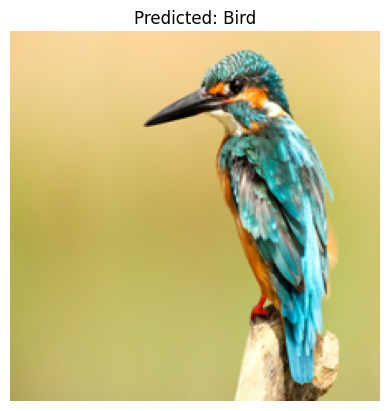


Image: /kaggle/input/vlm-sample-image/VLM_Dataset_Sample/Crow_image.jpg
Top-1: Crow  (prob: 0.880)
  Crow       -> 0.880
  Bird       -> 0.120
  Car        -> 0.000
  Bus        -> 0.000


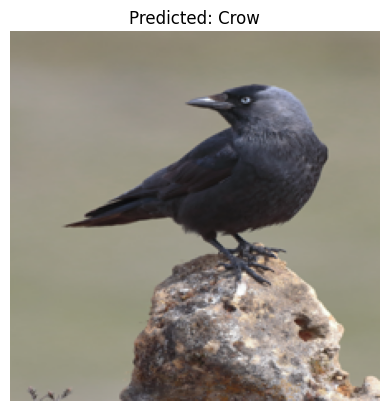


Image: /kaggle/input/vlm-sample-image/VLM_Dataset_Sample/Car_image.jpeg
Top-1: Car  (prob: 1.000)
  Car        -> 1.000
  Bird       -> 0.000
  Crow       -> 0.000
  Bus        -> 0.000


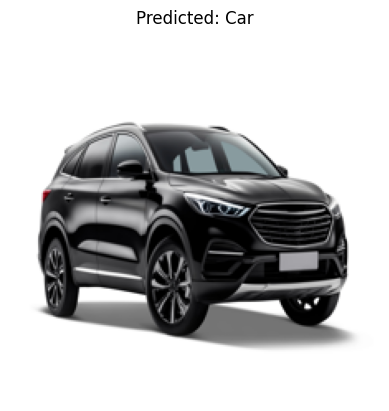


Image: /kaggle/input/vlm-sample-image/VLM_Dataset_Sample/Bus_image.jpg
Top-1: Bus  (prob: 0.977)
  Bus        -> 0.977
  Car        -> 0.022
  Bird       -> 0.000
  Crow       -> 0.000


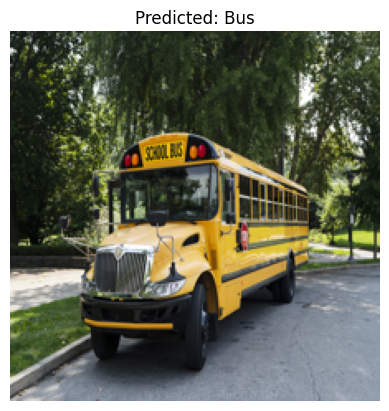

In [18]:
import matplotlib.pyplot as plt

for i, path in enumerate(image_paths):
    p = probs[i].detach().cpu() 
    # probs = softmax probabilities from CLIP (shape [num_images, num_labels]).
    # probs[i] → gives probability distribution for the i-th image across all labels.
    top_idx = torch.argmax(p).item() # Finds the index of the highest probability label for this image. and .item() converts it into a Python integer.
    
    print(f"\nImage: {path}") # prints the path name
    print(f"Top-1: {text[top_idx]}  (prob: {p[top_idx]:.3f})") # Prints the top predicted label and its probability (rounded to 3 decimals).
    
    for lbl, pr in sorted(zip(text, p.tolist()), key=lambda x: -x[1]):
        print(f"  {lbl:10s} -> {pr:.3f}") # prints the probability of all labels, Sorts by probability (highest first).
    
    # ---- Show the image resized to 224x224 with prediction ----
    img = Image.open(path).convert("RGB").resize((224, 224))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {text[top_idx]}", fontsize=12) # top_idx shows the image of top probability
    plt.show()

# End of notebook
Learned the following concepts

1. Download CLIP using transformer
2. How to use CLIP processor to obtain image and text embeddings
3. How to use obtain raw similarity scores (logits)
4. How to convert raw scores to probabilities using softmax.